# 🧪 Custom kNN Regression

In this notebook, we implement kNN regressor **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `KNeighborsRegressor` and `LinearRegression` models.

### ⚙️ Importing Libraries & Environment Setup

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [24]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [25]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, R2) for each model.
            Columns correspond to model names; rows correspond to metrics.
    """
    evaluations = pd.DataFrame(columns=predictions.keys(), index=["MAE", "MSE", "R2"])

    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        evaluations.loc[:, name] = [mae, mse, r2]

    return evaluations.astype(float)

In [26]:
def plot_regression_models(
    predictions: dict[str, NDArray[np.float64]],
    X: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
) -> None:
    """Plot regression results for multiple models on scatter data.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted values for X_test.
        X (NDArray[np.float64]): Original feature data of shape (n_samples, 1)
            for scatter plot.
        y (NDArray[np.float64]): True target values corresponding to X.
        X_test (NDArray[np.float64]): Feature values where predictions are
            evaluated and plotted.
    """
    sns.scatterplot(x=X.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")

    palette = sns.color_palette("Set1")
    for index, (name, y_pred) in enumerate(predictions.items()):
        sns.lineplot(
            x=X_test.flatten(),
            y=y_pred.flatten(),
            alpha=0.6,
            color=palette[index],
            label=name,
        )

    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [27]:
# Generate dataset
X, y = make_regression(
    n_samples=100, n_features=1, noise=10, bias=37.0, random_state=42
)

In [28]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [ ]:
class MyKNeighborsRegressor:
    """K-Nearest Neighbors Regressor with Gaussian kernel weighting.

    Predicts the target value for each input sample based on the weighted average
    of its k nearest neighbors in the training data, using Minkowski distance and
    Gaussian kernel for weighting.

    Attributes:
        k_neighbors (int): Number of nearest neighbors to consider.
        p (float): Power parameter for the Minkowski distance.
        h (float): Bandwidth parameter for the Gaussian kernel.
        X_train (NDArray[np.float64] | None): Training features.
        y_train (NDArray[np.float64] | None): Training targets.
    """

    def __init__(self, k_neighbors: int = 3, p: float = 2.0, h: float = 1.0) -> None:
        """Initialize the KNN regressor.

        Args:
            k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
            p (float, optional): Order of the Minkowski distance metric.
                Defaults to 2.0.
            h (float, optional): Bandwidth parameter for the Gaussian kernel.
                Defaults to 1.0.
        """
        self.k_neighbors = k_neighbors
        self.p = p
        self.h = h

        self.X_train: NDArray[np.float64] | None = None
        self.y_train: NDArray[np.float64] | None = None

    def _gaussian_kernel(self, t: NDArray[np.float64]) -> NDArray[np.float64]:
        """Gaussian (normal) kernel function.

        Args:
            t (NDArray[np.float64]): Input values.

        Returns:
            NDArray[np.float64]: Kernel-weighted values.
        """
        return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)

    def _get_distances(self, x: float) -> NDArray[np.float64]:
        """Compute Minkowski distances from a single sample to all training samples.

        Args:
            x (float): Single sample.

        Returns:
            NDArray: Distances from x to each sample in X_train.
        """
        return np.sum(np.abs(self.X_train - x) ** self.p, axis=1) ** (1 / self.p)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Store training data for future predictions.

        Args:
            X (NDArray[np.float64]): Training feature matrix of shape
                (n_samples, n_features).
            y (NDArray[np.float64]): Target values of shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values for samples in X.

        Args:
            X (NDArray[np.float64]): Input data of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values.
        """
        y_pred = []
        for x_new in X:
            distances = self._get_distances(x_new)

            neighbors_idx = distances.argsort()[: self.k_neighbors]
            neighbor_labels = y_train[neighbors_idx].astype(np.float64)
            neighbor_distances = distances[neighbors_idx]

            weights = self._gaussian_kernel(neighbor_distances / self.h)

            weighted_sum = np.sum(weights * neighbor_labels)
            weight_total = np.sum(weights)

            predicted_label = (
                weighted_sum / weight_total
                if weight_total != 0
                else np.mean(self.y_train)
            )
            y_pred.append(predicted_label)

        return np.array(y_pred, dtype=np.float64)

### 🏋️‍♂️ Model Training

In [30]:
# Scikit-learn linear regression model
sklearn_linear_model = LinearRegression()
sklearn_linear_model.fit(X_train, y_train)

# Scikit-learn kNN regressor model
sklearn_model = KNeighborsRegressor(n_neighbors=5, algorithm="brute")
sklearn_model.fit(X_train, y_train)

# My kNN regressor model
my_model = MyKNeighborsRegressor(k_neighbors=5, p=5, h=0.5)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [31]:
predictions = {
    "scikit-learn_linear": sklearn_linear_model.predict(X_test),
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [32]:
evaluate_regression_models(predictions, y_test)

,scikit-learn_linear,scikit-learn,my
MAE,8.416660,8.674021,8.683998
MSE,104.202227,108.141989,108.167394
R2,0.937415,0.935049,0.935034


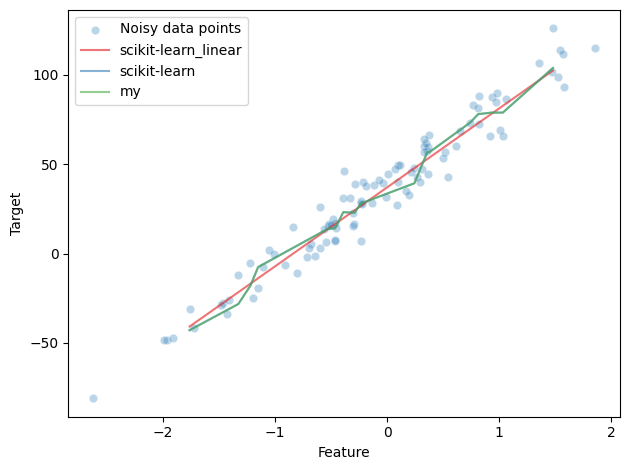

In [33]:
plot_regression_models(predictions, X, y, X_test)